#"GeneSeqML": Empowering Gene Function Prediction through DNA Sequencing and Machine Learning
Description: An intelligent classification model that harnesses the potential of DNA sequencing and machine learning to predict gene function, enabling precise annotations and deeper understanding of genetic information

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from prettytable import PrettyTable
%matplotlib inline

##Dataset:

Description: The [dataset](https://www.kaggle.com/datasets/nageshsingh/dna-sequence-dataset) used in this project comprises DNA sequence coding regions along with corresponding class labels for human, chimpanzee, and dog. It provides a valuable resource for investigating gene function prediction across species. The dataset includes genetic information specifically from coding regions, which are crucial for understanding gene expression and functional characteristics. By incorporating data from multiple species, including the closely related chimpanzee and the more divergent dog, the dataset allows for comparative genomics analysis and insights into evolutionary patterns.

In [66]:
%cd "/content/drive/MyDrive/Gene_project"

/content/drive/MyDrive/Gene_project


In [67]:
h_data = pd.read_table('human.txt')
h_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [68]:
c_data = pd.read_table('chimpanzee.txt')
d_data = pd.read_table('dog.txt')
c_data.head()
d_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


### Treating DNA sequence as a "language", otherwise known as  k-mer counting.

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method is inspired by the seminal paper: **[An open-source k-mer based machine learning tool for fast and accurate subtyping of HIV-1 genomes](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0206409)**. In this method, long biological sequence is taken and broken down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

In this code, hexamer “words” are used. However, the word length and amount of overlap need to be determined empirically for any given application.



### Function to collect all possible overlapping k-mers of a specified length from any sequence string.

In [69]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [70]:
h_data['words'] = h_data.apply(lambda x: getKmers(x['sequence']), axis=1)
h_data = h_data.drop('sequence', axis=1)
c_data['words'] = c_data.apply(lambda x: getKmers(x['sequence']), axis=1)
c_data = c_data.drop('sequence', axis=1)
d_data['words'] = d_data.apply(lambda x: getKmers(x['sequence']), axis=1)
d_data = d_data.drop('sequence', axis=1)

In [71]:
h_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


Converting the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.  Also making y variable to hold the class labels.

In [72]:
h_texts = list(h_data['words'])
for item in range(len(h_texts)):
    h_texts[item] = ' '.join(h_texts[item])
y_data = h_data.iloc[:, 0].values

In [73]:
print(h_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [74]:
y_data

array([4, 4, 3, ..., 6, 6, 6])

Performing the same steps for chimpanzee and dog dataset

In [75]:
c_texts = list(c_data['words'])
for item in range(len(c_data)):
    c_texts[item] = ' '.join(c_texts[item])
y_chimp = c_data.iloc[:, 0].values

d_texts = list(d_data['words'])
for item in range(len(d_texts)):
    d_texts[item] = ' '.join(d_texts[item])
y_dog = d_data.iloc[:, 0].values

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [76]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(h_texts)
X_chimp = cv.transform(c_texts)
X_dog = cv.transform(d_texts)

In [77]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(2206, 232414)
(820, 232414)


## Training and Testing on Human Dataset

Text(0, 0.5, 'Count')

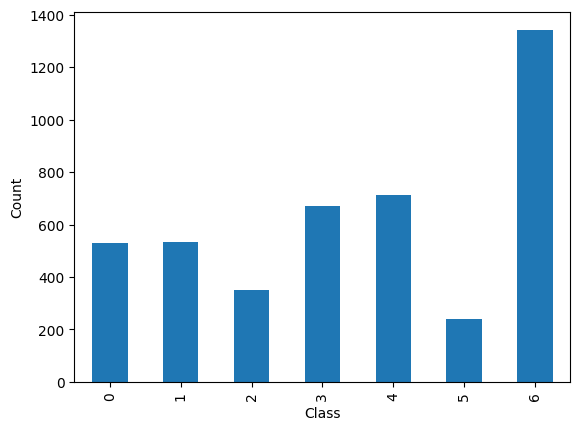

In [119]:
# Analysing class distribution
h_data['class'].value_counts().sort_index().plot.bar()
plt.xlabel('Class')
plt.ylabel('Count')

In [79]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_data,
                                                    test_size = 0.20,
                                                    random_state=42)

In [80]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [81]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

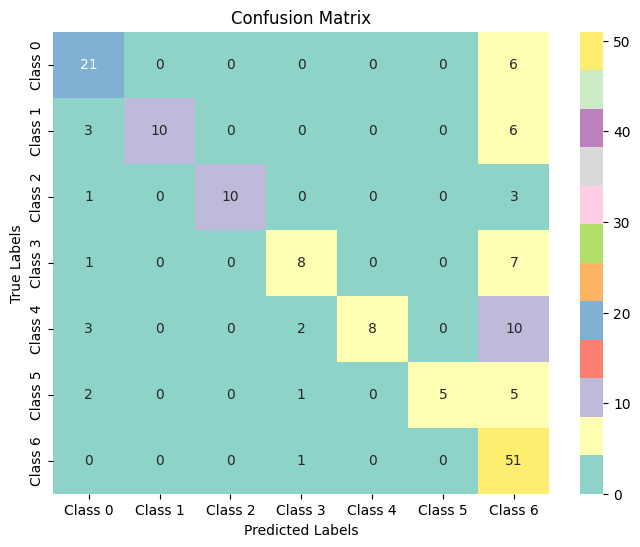

In [115]:
y_pred = classifier.predict(X_test)


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels (replace 'class_labels' with your actual class labels)
class_labels = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Set3', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [83]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy_h, precision_h, recall_h, f1_h = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_h, precision_h, recall_h, f1_h))

accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


## Training and Testing on Chimpanzee Dataset

Text(0, 0.5, 'Count')

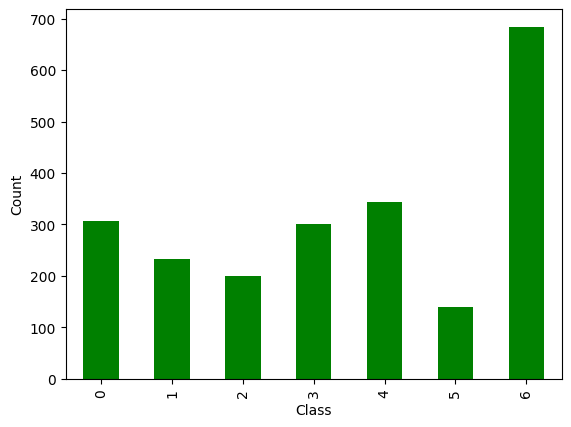

In [122]:
c_data['class'].value_counts().sort_index().plot.bar(color='green')
plt.xlabel('Class')
plt.ylabel('Count')

In [85]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_chimp,
                                                    y_chimp,
                                                    test_size = 0.20,
                                                    random_state=42)

In [86]:
print(X_train.shape)
print(X_test.shape)

(1764, 232414)
(442, 232414)


In [87]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

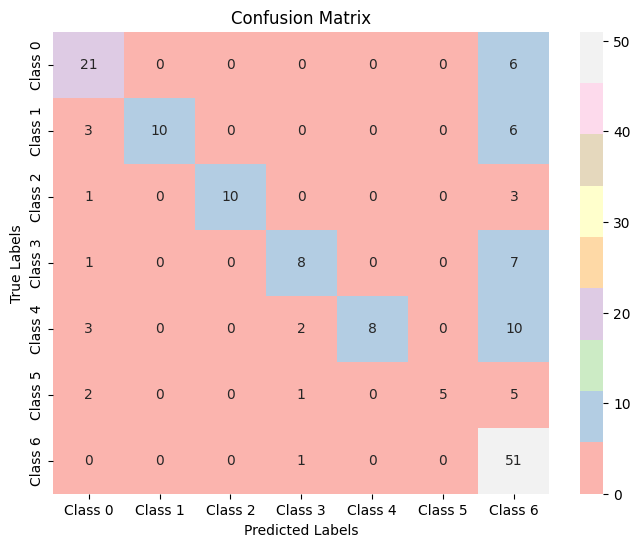

In [116]:
y_pred = classifier.predict(X_test)


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels (replace 'class_labels' with your actual class labels)
class_labels = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [89]:
accuracy_c, precision_c, recall_c, f1_c = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_c, precision_c, recall_c, f1_c))

accuracy = 0.914 
precision = 0.927 
recall = 0.914 
f1 = 0.914


In [90]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(2206, 232414)
(820, 232414)


## Training and Testing on Dog Dataset

Text(0, 0.5, 'Count')

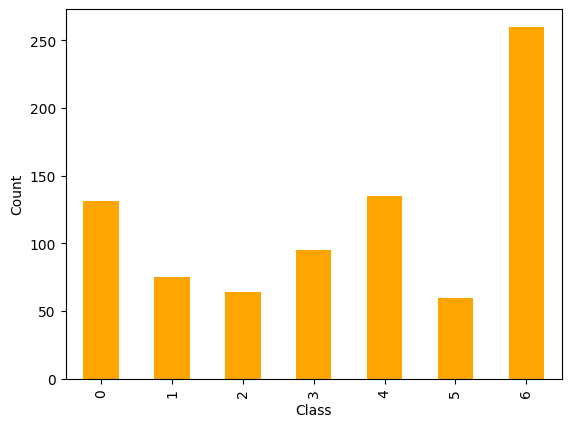

In [125]:
d_data['class'].value_counts().sort_index().plot.bar(color='orange')
plt.xlabel('Class')
plt.ylabel('Count')

In [92]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dog,
                                                    y_dog,
                                                    test_size = 0.20,
                                                    random_state=42)

In [93]:
print(X_train.shape)
print(X_test.shape)

(656, 232414)
(164, 232414)


In [94]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

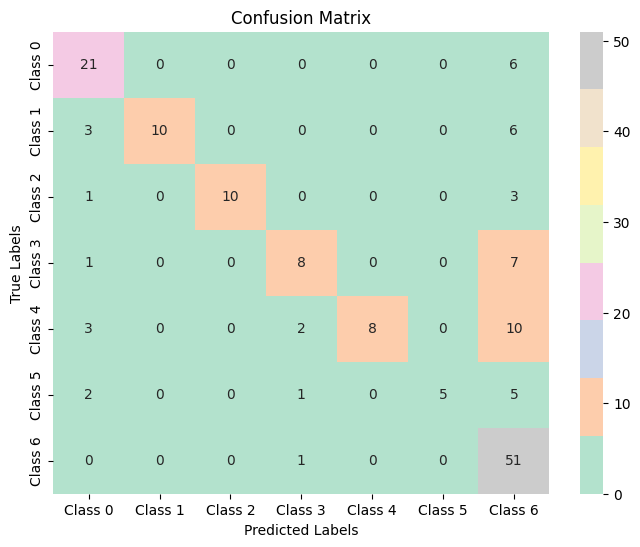

In [118]:
y_pred = classifier.predict(X_test)


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels (replace 'class_labels' with your actual class labels)
class_labels = ['Class 0','Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel2', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [96]:
accuracy_d, precision_d, recall_d, f1_d = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy_d, precision_d, recall_d, f1_d))

accuracy = 0.689 
precision = 0.781 
recall = 0.689 
f1 = 0.673


## Inference

In [99]:
# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ['Dataset', 'Accuracy', 'Precision', 'F1 Score', 'Recall']

# Add rows to the table
table.add_row(['Human', round(accuracy_h,3), round(precision_h,3), round(f1_h,3), round(recall_h,3)])
table.add_row(['Chimpanzee', round(accuracy_c,3), round(precision_c,3), round(f1_c,3), round(recall_c,3)])
table.add_row(['Dog', round(accuracy_d,3), round(precision_d,3), round(f1_d,3), round(recall_d,3)])

# Print the table
print(table)


+------------+----------+-----------+----------+--------+
|  Dataset   | Accuracy | Precision | F1 Score | Recall |
+------------+----------+-----------+----------+--------+
|   Human    |  0.984   |   0.984   |  0.984   | 0.984  |
| Chimpanzee |  0.914   |   0.927   |  0.914   | 0.914  |
|    Dog     |  0.689   |   0.781   |  0.673   | 0.689  |
+------------+----------+-----------+----------+--------+


In inference, the accuracy results suggest that the Multinomial Naive Bayes classifier performs very well in distinguishing between human and chimpanzee DNA sequences. However, it faces greater challenges when it comes to accurately classifying dog DNA sequences. This could indicate that the genetic differences between humans and chimpanzees are more distinct and discernible, while the genetic variations among dogs might be more complex or less easily captured by the classifier.